# Vehicle-Detection-and-Tracking

The goals/steps of this project are the following:
 
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *

## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images 

I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

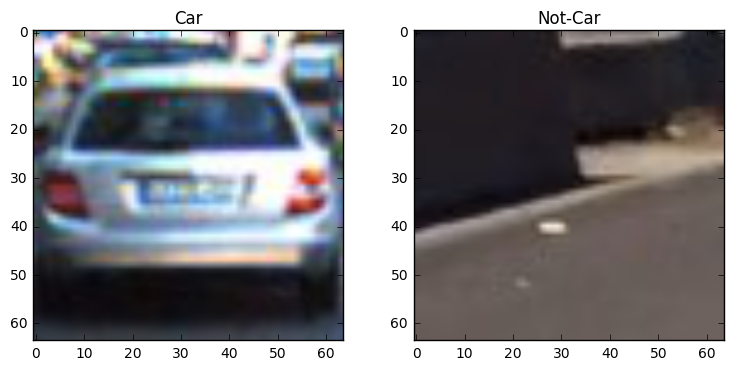

In [29]:
car_img=mpimg.imread('test_images/car.jpeg')
notcar_img=mpimg.imread('test_images/notcar.jpeg')
fig,ax=plt.subplots(1,2,figsize=(9,4))
ax[0].set_title('Car')
ax[0].imshow(car_img)
ax[1].set_title('Not-Car')
ax[1].imshow(notcar_img)
plt.savefig('output_images/car-notcar.jpg')
plt.show()

In this section,I used the scikit-image `hog()` function
to extract Histogram of Oriented Gradient features.The 
paramters include: orientations,pixels_per_cell and cells_per_block.Different color spaces and `hog()` parameters were tried to get the best combined feature vector for the detection task.Here is an example using
YCrCb color space and HOG paramters of `orientations=8`,
`pixels_per_cell=(8,8)` and `cells_per_block=(2,2)`:

In [90]:
# %load lesson_functions.py
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

# Define a function to convert Color Spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img,scale=1.0, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_ratio=(1.0, 1.0),xy_overlap=(0.5,0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    #scale xy ratio
    xy_window[0]=np.int(xy_window[0]*scale)
    xy_window[1]=np.int(xy_window[1]*scale)
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*xy_ratio[0]*xy_overlap[0])
    ny_pix_per_step = np.int(xy_window[1]*xy_ratio[1]*xy_overlap[1])
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*xy_ratio[0])
    ny_buffer = np.int(xy_window[1]*xy_ratio[1])
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)+1 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)+1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


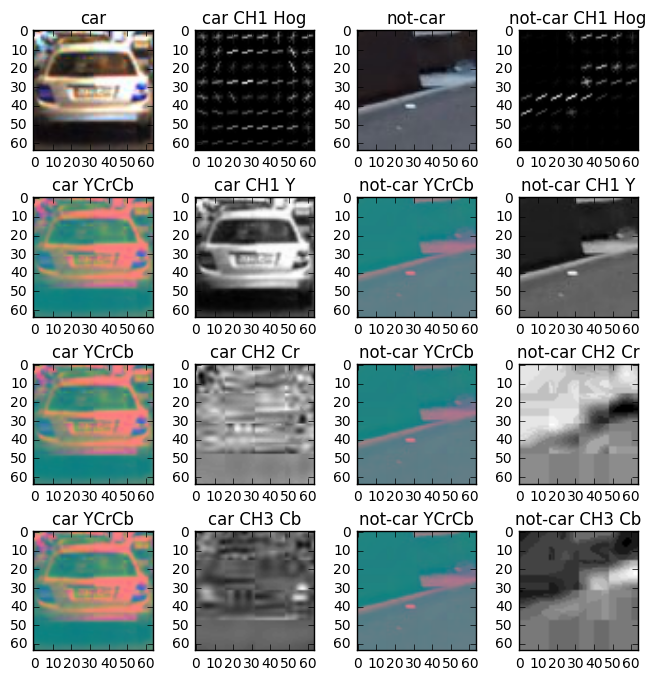

In [110]:
car=cv2.imread('test_images/car.jpeg')
notcar=cv2.imread('test_images/notcar.jpeg')

color_space = 'RGB2YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "0" # Can be 0, 1, 2, or "ALL"

#color features
car_color=convert_color(car,color_space)
notcar_color=convert_color(notcar,color_space)

car_channel1=car_color[:,:,0]
car_channel2=car_color[:,:,1]
car_channel3=car_color[:,:,2]
notcar_channel1=notcar_color[:,:,0]
notcar_channel2=notcar_color[:,:,1]
notcar_channel3=notcar_color[:,:,2]

#hog features
carfeature1,car_hog_channel1=get_hog_features(car_channel1,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=False)
notcarfeature1,notcar_hog_channel1=get_hog_features(notcar_channel1,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=False)

img=mpimg.imread('test_images/car.jpeg')
res=single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(8,8))
#col=1
axes[0,0].set_title('car');
axes[0,0].imshow(car)
axes[1,0].set_title('car YCrCb');
axes[1,0].imshow(car_color,cmap='gray')
axes[2,0].set_title('car YCrCb');
axes[2,0].imshow(car_color,cmap='gray')
axes[3,0].set_title('car YCrCb');
axes[3,0].imshow(car_color,cmap='gray')
#col=2
axes[0,1].set_title('car CH1 Hog');
axes[0,1].imshow(car_hog_channel1,cmap='gray')
axes[1,1].set_title('car CH1 Y');
axes[1,1].imshow(car_channel1,cmap='gray')
axes[2,1].set_title('car CH2 Cr');
axes[2,1].imshow(car_channel2,cmap='gray')
axes[3,1].set_title('car CH3 Cb');
axes[3,1].imshow(car_channel3,cmap='gray')
#col=3
axes[0,2].set_title('not-car');
axes[0,2].imshow(notcar,)
axes[1,2].set_title('not-car YCrCb');
axes[1,2].imshow(notcar_color,cmap='gray')
axes[2,2].set_title('not-car YCrCb');
axes[2,2].imshow(notcar_color,cmap='gray')
axes[3,2].set_title('not-car YCrCb');
axes[3,2].imshow(notcar_color,cmap='gray')
#col=4
axes[0,3].set_title('not-car CH1 Hog');
axes[0,3].imshow(notcar_hog_channel1,cmap='gray')
axes[1,3].set_title('not-car CH1 Y');
axes[1,3].imshow(notcar_channel1,cmap='gray')
axes[2,3].set_title('not-car CH2 Cr');
axes[2,3].imshow(notcar_channel2,cmap='gray')
axes[3,3].set_title('not-car CH3 Cb');
axes[3,3].imshow(notcar_channel3,cmap='gray')
fig.subplots_adjust(hspace=0.4)
#plt.savefig('output_images/hog_features.jpg')
plt.show()


## Train a classifier using the extracted HOG features

I trained a linear SVM using 'LinearSVC' function from sklearn.svm package.And Here is the training pipeline:
* Step1:Normalize the data.Use sklearn.preprocessing.StandardScaler() to normalize extracted feature vectors for the training classifier.
* Step2:Random Shuffling the data.Use sklearn.cross_validation.train_test_split() to shuffle and split the data into training and testing sets.
* Step3：Define the train classifier.Use sklearn.svm.LinearSVC() to create a classifier called linear SVM(Support Vector Machine),which is very suitable for classify HOG features.
* Step4: Train and Test.This step is doing the training and testing process.While training the data,I can check the accuary of the classifier on the test dataset.We can see the accuary is rising to a high score greater than 0.9,closing to 1.

Here is the inplementation details.

In [3]:
#read dataset
import glob
#read dataset in vehicles and non-vehicles
GTI_Far=glob.glob('dataset/vehicles/GTI_Far/*.png')
GTI_Left=glob.glob('dataset/vehicles/GTI_Left/*.png')
GTI_MiddleClose=glob.glob('dataset/vehicles/GTI_MiddleClose/*.png')
GTI_Right=glob.glob('dataset/vehicles/GTI_Right/*.png')
KITTI_extracted=glob.glob('dataset/vehicles/KITTI_extracted/*.png')

vehicles=GTI_Far+GTI_Left+GTI_MiddleClose+GTI_Right+KITTI_extracted
print(len(GTI_Far))
print(len(GTI_Left))
print(len(GTI_Right))
print(len(GTI_MiddleClose))
print(len(KITTI_extracted))
print(len(vehicles))
print(vehicles[0])
#none vehicles
Extras=glob.glob('dataset/non-vehicles/Extras/*.png')
GTI=glob.glob('dataset/non-vehicles/GTI/*.png')
nonvehicles=Extras+GTI
print(len(Extras))
print(len(GTI))
print(len(nonvehicles))

834
909
665
419
5966
8793
dataset/vehicles/GTI_Far\image0000.png
5068
3900
8968


In [83]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import grid_search,svm
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog

# Read in cars and notcars
images = glob.glob('data/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)


        
#data
#cars=vehicles
#notcars=nonvehicles
print(len(cars))
print(len(notcars))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 1125
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]


### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svr = svm.SVC()
#paramters
parameters={'kernel':('linear','rbf'),'C':[1,10]}
svc = grid_search.GridSearchCV(svr, parameters) 
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

1198
1125
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5340
48.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9914


##  Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

The sliding-window technique here is simple,define the region of the roi,roi size and the overlap 
of neighboring windows.Then slide from top-left to bottom-right and we can get a number of windows.
However,I defined several different scales of windows in the algorithm.The scales are[0.6,0.8,1.0,1.2,1.4,1.6] ratios of size[64,64].So diffe

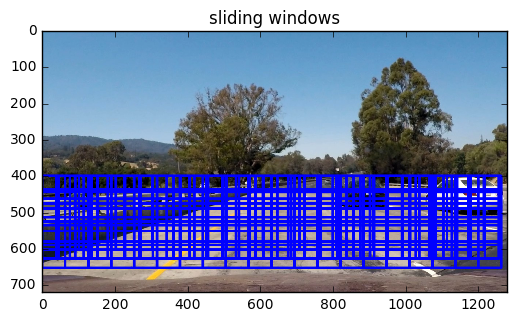

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

img=mpimg.imread('test_images/test1.jpg')

y_start_stop=[400, 656]# Min and max in y to search in slide_window()

scales=[0.8,1.0,1.2,1.4,1.6,1.8]
windows=[]
xy_window=[96,96]
for scale in scales:
    xy_window[0]=int(xy_window[0]*scale)
    xy_window[1]=int(xy_window[1]*scale)
    res_windows=slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))
    windows=windows+res_windows
    
bbox_image=draw_boxes(img,windows)

plt.title('sliding windows')
plt.imshow(bbox_image)
plt.savefig('output_images/slide_image.jpg')
plt.show()

In [93]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

288
210
162
128
98
78
55
50
1069


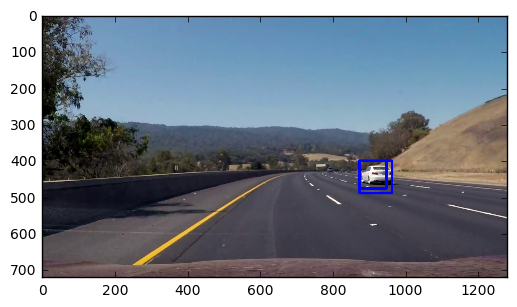

In [105]:
image = mpimg.imread('project/642.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
#TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop=[300,1280]
scales=[1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6]
windows=[]
#scale=2
for scale in scales:
    tmp_windows = slide_window(image,scale,x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                               xy_window=[64, 64], xy_ratio=(1.0, 0.5),xy_overlap=(0.5,0.5))
    print(len(tmp_windows))
    windows.extend(tmp_windows)
    
    
print(len(windows))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

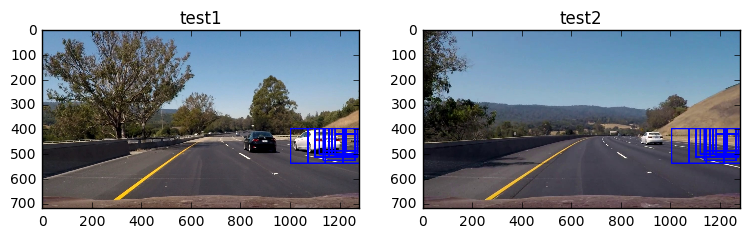

In [100]:

xstart=300
xstop=1200
ystart = 400
ystop = 656
scales=[1.8,2.0,2.2,2.4]
spatial_feat=False
hist_feat=True

#loop scales for test images
img=mpimg.imread('test/test6.jpg')
draw_image=img.copy()
for scale in scales:
    tmp_windows = slide_window(image,scale,x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                               xy_window=[64, 64], xy_ratio=(1.0, 0.5),xy_overlap=(0.5,0.5))
    windows.extend(tmp_windows)
        
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
test1 = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)      

img=mpimg.imread('project/642.jpg')
draw_image=img.copy()
for scale in scales:
    tmp_windows = slide_window(image,scale,x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                               xy_window=[64, 64], xy_ratio=(1.0, 0.5),xy_overlap=(0.5,0.5))
    windows.extend(tmp_windows)
        
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
test2 = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        
fig,axes=plt.subplots(1,2,figsize=(9,4))
axes[0].set_title('test1')
axes[0].imshow(test1)
axes[1].set_title('test2')
axes[1].imshow(test2)
#plt.savefig('output_images/test_result.jpg')
plt.show()

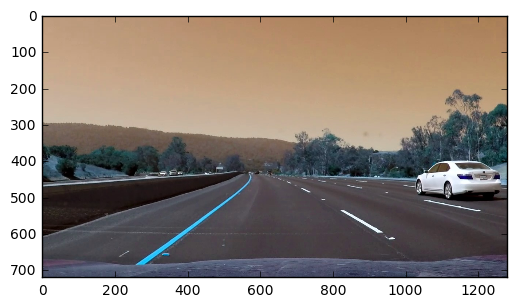

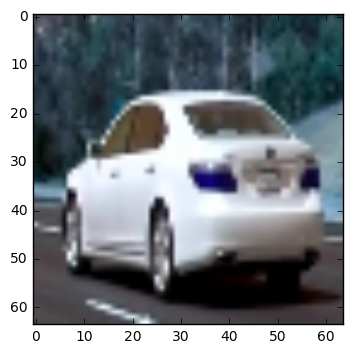

In [73]:
img=cv2.imread('project/263.jpg')
roi=img[360:520,1000:1280]
res=cv2.resize(roi,(64,64))
#res=cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
cv2.imwrite('image0000.jpg',res)
fig=plt.figure()
plt.imshow(img)
fig1=plt.figure()
plt.imshow(res)
plt.show()

## Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Here is a link to my video result

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.
Here's an example result showing the heatmap from a series of frames of video, the result of scipy.ndimage.measurements.label() and the bounding boxes then overlaid on the last frame of video

2


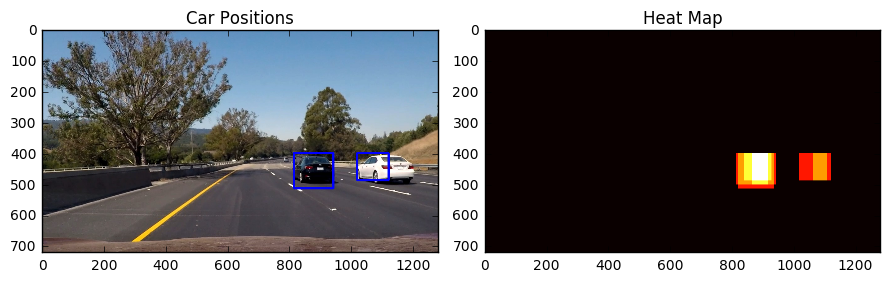

In [57]:
#find the only result using heat map

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
box_list=res_box1

# Read in image similar to one shown above 
image = mpimg.imread('test/test6.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bboxes=[]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img,bboxes

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img,bboxes = draw_labeled_bboxes(np.copy(image), labels)
print(len(bboxes))
#cv2.imwrite('output_images/final_result.jpg',draw_img)
fig = plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
#plt.savefig('output_images/heat result.jpg')
plt.show()

2 cars found


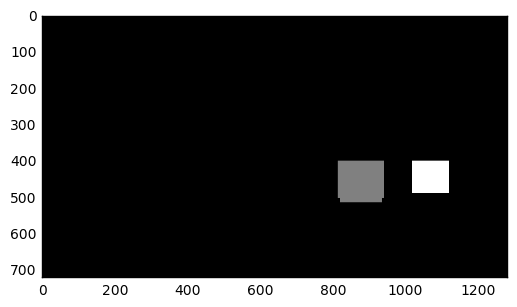

In [53]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
#plt.savefig('output_images/single result.jpg')
plt.show()

## Video Process

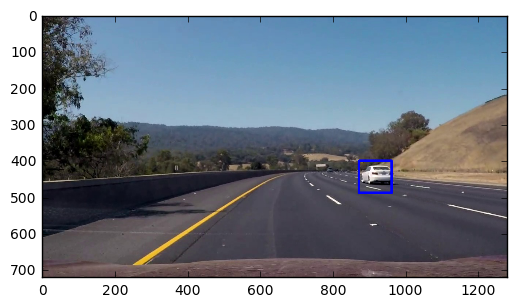

In [106]:
#define process functions
def process(img):
    #1.find boxes
    #TODO: Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400, 656] # Min and max in y to search in slide_window()
    x_start_stop = [300,1280]
    scales=[1.2,1.4,1.6,1.8,2.0,2.2,2.4]
    windows=[]
    for scale in scales:
        for scale in scales:
            tmp_windows = slide_window(image,scale,x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                               xy_window=[64, 64], xy_ratio=(1.0, 0.5),xy_overlap=(0.5,0.5))
            windows.extend(tmp_windows)
        
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
        #2.find the single output
        heat=np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)    
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        result_img,bboxes = draw_labeled_bboxes(np.copy(img), labels)
        
    return result_img

img=mpimg.imread('project/642.jpg')
result=process(img)
plt.imshow(result)
plt.show()

In [115]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

#process videos
output_path='output_videos/test_video_result.mp4'
project_clip=VideoFileClip("test_video.mp4")
clip=project_clip.fl_image(process)
%time clip.write_videofile(output_path,audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:46<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 47.8 s


In [116]:
#process videos
output_path='output_videos/project_video_result.mp4'
project_clip=VideoFileClip("project_video.mp4")
clip=project_clip.fl_image(process)
%time clip.write_videofile(output_path,audio=False)

[MoviePy] >>>> Building video output_videos/project_video_result.mp4
[MoviePy] Writing video output_videos/project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:01<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_result.mp4 

Wall time: 26min 2s


In [40]:
#test images
import glob
images=glob.glob('project/*.jpg')
total=len(images)
print(len(images))
for i in range(total):
    if(i>10):
        break
    image='project/'+str(i)+'.jpg'
    img=mpimg.imread(image)    
    res=process(img)
    savepath='output/'+str(i)+'.jpg'
    result=cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
    cv2.imwrite(savepath,result)
    i=i+1
    print('num=',i)

1253
num= 1
num= 2
num= 3
num= 4
num= 5
num= 6
num= 7
num= 8
num= 9
num= 10
num= 11


In [33]:
img=mpimg.imread('project/0.jpg')

In [34]:
img[0,0]

array([105, 144, 183], dtype=uint8)

In [35]:
img=mpimg.imread('dataset/vehicles/GTI_Far/image0000.png')

In [36]:
img[0,0]

array([ 0.61176473,  0.65882355,  0.63921571], dtype=float32)